In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm

In [3]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert MNIST to RGB format
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
device = torch.device("cuda")

In [5]:
# training dataset called "train_data" using the MNIST dataset from the 'mnist_data' directory
train_data = torchvision.datasets.MNIST('mnist_data',train=True , download=True , transform =transform)
# validation dataset called "val_data" using the MNIST dataset from the 'mnist_data' directory.
val_data = torchvision.datasets.MNIST('mnist_data',train=False , download=True , transform =transform)

train_dl = torch.utils.data.DataLoader(train_data, batch_size=64)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=64)

100%|██████████| 9912422/9912422 [00:00<00:00, 317604589.96it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26106830.57it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 150998698.64it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 22491769.50it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [29]:
len(val_data)

10000

In [ ]:
len(val_dl)

157

In [6]:
# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


In [7]:
# Modify the model for MNIST
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)


In [8]:

# Set the model to training mode
model.train()



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [10]:
# Define a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Adjust step_size and gamma as needed

In [11]:
model = model.to(device)

In [36]:
mnist_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 342810472.09it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 36268171.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 73152297.91it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15338589.99it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [37]:
data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=False)

In [16]:
true_labels = []
predicted_labels = []


In [38]:
model = model.to(device)
num_epochs = 5
best_accuracy = 0.0

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    true_labels = []  # Initialize true_labels for this epoch
    predicted_labels = []  # Initialize predicted_labels for this epoch

    # Use tqdm to display a progress bar
    for images, labels in tqdm(data_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        optimizer.zero_grad()

        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Now, you can safely pass the input through the model
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Convert tensors to numpy arrays and append to the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Loss: {running_loss/len(train_dl):.4f}, Accuracy: {accuracy:.2f}%')

# After all epochs are completed
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels)

print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Epoch 1/5: 100%|██████████| 157/157 [00:45<00:00,  3.45it/s]


Loss: 0.0000, Accuracy: 100.00%


Epoch 2/5: 100%|██████████| 157/157 [00:44<00:00,  3.49it/s]


Loss: 0.0000, Accuracy: 100.00%


Epoch 3/5: 100%|██████████| 157/157 [00:45<00:00,  3.46it/s]


Loss: 0.0000, Accuracy: 100.00%


Epoch 4/5: 100%|██████████| 157/157 [00:45<00:00,  3.46it/s]


Loss: 0.0000, Accuracy: 100.00%


Epoch 5/5: 100%|██████████| 157/157 [00:45<00:00,  3.47it/s]

Loss: 0.0000, Accuracy: 100.00%
Confusion Matrix:
[[ 980    0    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0    0 1032    0    0    0    0    0    0    0]
 [   0    0    0 1010    0    0    0    0    0    0]
 [   0    0    0    0  982    0    0    0    0    0]
 [   0    0    0    0    0  892    0    0    0    0]
 [   0    0    0    0    0    0  958    0    0    0]
 [   0    0    0    0    0    0    0 1028    0    0]
 [   0    0    0    0    0    0    0    0  974    0]
 [   0    0    0    0    0    0    0    0    0 1009]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       1.00      1.00      1.00       982
           5       1.00      1.00      1.00       892
           6     

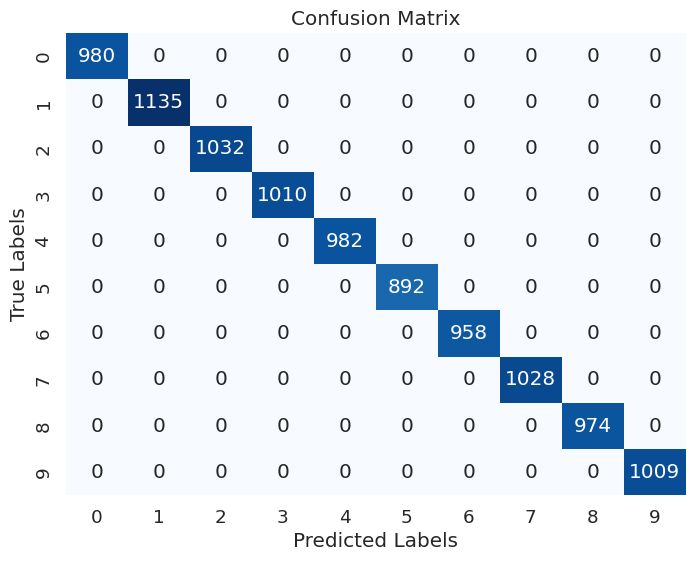

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels)

print(f'Epoch {epoch+1}/{num_epochs}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


ValueError: ignored